# Using Neural Networks to Shortlist Resumes

Yea.. We're doing exactly that.

## Loading up the Stuff
Anway, let's first begin by importing all the necessary libraries we need for now.

In [1]:
import numpy as np    # Linalg
import pandas as pd   # csv processing
import nltk           # NLP library for tokenising
import re             # regex evaluation

# Necessary packages needed for nltk to tokenize the words.
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/devansh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/devansh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/devansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/devansh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Let's now load up our dataset and look at the content.

In [2]:
path = 'data/resume_data.csv'
df = pd.read_csv(path)

df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Strategy

So from here, we'll take our data and make two more datasets out of it:

- **Tabular Dataset** - This will contain features like degree, experience, job field etc. which we will feed to an MLP.

- **Tokenised Text Dataset** - We'll tokenize the resume text and then do some processing to convert it to feature vectors of fixed size, which will be fed to an LSTM.

After this, we will take the final layers (before the output) of both models, concatenate them and send them through another MLP to predict the probability of a resume being shortlisted.

Let's now work on the data splitting.

## Data Splitting and Processing
Let's first work on the tabular data which will be used by the MLP.

In [3]:
def extract_degree_level(text):

    # Keywords for each degree to look at
    phd_keywords = ['phd', 'ph.d', 'doctorate']
    masters_keywords = ['master of', "master's", 'msc', 'm.s.', 'm.tech', 'm.eng', 'mca', 'pgdm', 'post graduate']
    bachelors_keywords = ['b.tech', 'b.e', 'ba', 'b.a.', 'b.sc', 'bachelor of']
    diploma_keywords = ['diploma', 'polytechnic']
    highschool_keywords = ['high school', 'secondary education']


    # Convert the text to lowercase, return the necessary degree
    text = text.lower()

    for kw in phd_keywords:
        if kw in text:
            return 'phd'

    for kw in masters_keywords:
        if kw in text:
            return 'masters'

    for kw in bachelors_keywords:
        if kw in text:
            return 'bachelors'

    for kw in diploma_keywords:
        if kw in text:
            return 'diploma'

    for kw in highschool_keywords:
        if kw in text:
            return 'highschool'

    return 'none'

def extract_experience(text):
    # Another function to extract experience in anything in months. Won't be useful if the number is in text.
    text = text.lower()

    # Extract years
    years = re.findall(r'(\d+(?:\.\d+)?)\s*(?:\+)?\s*years?', text)
    total_years = sum(float(y) for y in years)

    # Extract months
    months = re.findall(r'(\d+(?:\.\d+)?)\s*months?', text)
    total_months = sum(float(m) for m in months)

    # Final total in months
    experience_months = int(total_years * 12 + total_months)
    return experience_months

def extract_field_of_study(text):
    # Finding out their field of study, again using keywords

    field_keywords = {
    'computer science': ['computer science', 'cse', 'cs', 'computer engineering', 'software engineering'],
    'electronics': ['electronics and communication', 'ece', 'electronics', 'e&c'],
    'electrical': ['electrical engineering', 'ee', 'electrical'],
    'information technology': ['information technology', 'it'],
    'mechanical': ['mechanical engineering', 'mechanical'],
    'civil': ['civil engineering', 'civil'],
    'data science': ['data science', 'analytics', 'business analytics'],
    'mathematics': ['mathematics', 'maths', 'statistics', 'applied mathematics'],
    'physics': ['physics'],
    'chemistry': ['chemistry'],
    'management': ['management', 'mba', 'business administration', 'pgdm'],
    'biotechnology': ['biotechnology', 'bioinformatics'],
    'chemical': ['chemical engineering', 'chemical'],
    'instrumentation': ['instrumentation engineering', 'instrumentation'],
    'science': ['science']
    }

    text = text.lower()
    for field, keywords in field_keywords.items():
        for kw in keywords:
            if kw in text:
                return field
    return 'other'

def extract_tabular_features(df):
  # Apply everything and return it on a separate dataframe
  df_t = df.copy()
  df_t['degree'] = df_t['Resume'].apply(extract_degree_level)
  df_t['experience'] = df_t['Resume'].apply(extract_experience)
  df_t['field_of_study'] = df_t['Resume'].apply(extract_field_of_study)
  return df_t

df_with_tabular = extract_tabular_features(df)
df_with_tabular

,Category,Resume,degree,experience,field_of_study
0,Data Science,Skills * Programming Languages: Python (pandas...,bachelors,72,computer science
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,bachelors,84,information technology
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",bachelors,96,computer science
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,masters,149,computer science
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",masters,72,information technology
...,...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,bachelors,18,electrical
958,Testing,â Willingness to accept the challenges. â ...,bachelors,24,computer science
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",bachelors,0,electrical
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,bachelors,18,computer science


Looks good enough, but we can't work with text.

Next, we perform encoding on the necessary tabular columns and scale the experience.

In [4]:
# Importing all the encoders we will use and the standard scaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
label_enc = LabelEncoder()


def encode_tabular_data(df):
  # Do the needful encoding and scaling and return the final feature matrix
  X_cat = encoder.fit_transform(df[['degree', 'field_of_study']])
  scaler = StandardScaler()
  X_num = scaler.fit_transform(df[['experience']])
  label_enc = LabelEncoder()
  y = label_enc.fit_transform(df['Category'])
  X = np.hstack([X_cat, X_num])
  return X

encode_tabular_data(df_with_tabular)

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.16006071],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         1.        , -0.11310057],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.06614042],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.44182159],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.37138137],
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.08962049]])

Now that we've had our data in a less understandable format, let's work on the textual data which will be fed to the LSTM.

Given below is a function that cleans the resume text, removes all digits and special characters, commonly used words, tokenizes and lemmatizes the text, and returns the resume as a space separated list of the extracted tokens.

In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

df_tabular_and_textual = df_with_tabular.copy()
df_tabular_and_textual['cleaned_resume'] = df['Resume'].apply(clean_text)
df_tabular_and_textual

,Category,Resume,degree,experience,field_of_study,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,bachelors,72,computer science,skill programming language python panda numpy ...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,bachelors,84,information technology,education detail may may uitrgpv data scientis...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",bachelors,96,computer science,area interest deep learning control system des...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,masters,149,computer science,skill r python sap hana tableau sap hana sql s...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",masters,72,information technology,education detail mca ymcaust faridabad haryana...
...,...,...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,bachelors,18,electrical,computer skill proficient m office word basic ...
958,Testing,â Willingness to accept the challenges. â ...,bachelors,24,computer science,willingness accept challenge positive thinking...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",bachelors,0,electrical,personal skill quick learner eagerness learn n...
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,bachelors,18,computer science,computer skill software knowledge mspower poin...


Well, now the cleaned text looks a lot better to look at! Next, we will convert each token to a unique index number and then convert the token lists to sequences of numbers, which will be fed into the LSTM.

Normally resumes are of different sizes, so we may need to pad them up with some value. However, if a resume if particularly long, then the padding for the other points will interfere with the LSTM training. Hence, we keep a limit on the sequence length, which is 200 for now.

In [6]:
from collections import Counter

# Convert the tokens to a list and store them all in a single list
df_tabular_and_textual['tokens'] = df_tabular_and_textual['cleaned_resume'].apply(word_tokenize)
all_tokens = [word for tokens in df_tabular_and_textual['tokens'] for word in tokens]

# Store the words and their frequencies (needed for words which are rare byt here all are common but keeping it for formality)
word_counts = Counter(all_tokens)

# Vocabulary list, has two strings for padding and unknown words
vocab = ['<PAD>','<UNK>'] + [word for word,_ in word_counts.items()]

# The dictionary which assigns an index to each value in the vocab
index = {word:idx for idx,word in enumerate(vocab)}

# Convert all known tokens to their respective indices or mark them as unknown
def tokens_to_indices(tokens):
  return [index.get(token, index['<UNK>']) for token in tokens]

max_token_seq_length = 200

df_tabular_and_textual['seq'] = df_tabular_and_textual['tokens'].apply(lambda tokens: tokens[:max_token_seq_length]).apply(tokens_to_indices)
df_tabular_and_textual

,Category,Resume,degree,experience,field_of_study,cleaned_resume,tokens,seq
0,Data Science,Skills * Programming Languages: Python (pandas...,bachelors,72,computer science,skill programming language python panda numpy ...,"[skill, programming, language, python, panda, ...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,bachelors,84,information technology,education detail may may uitrgpv data scientis...,"[education, detail, may, may, uitrgpv, data, s...","[311, 74, 312, 312, 313, 75, 314, 75, 314, 315..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",bachelors,96,computer science,area interest deep learning control system des...,"[area, interest, deep, learning, control, syst...","[367, 368, 72, 15, 369, 300, 370, 3, 371, 372,..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,masters,149,computer science,skill r python sap hana tableau sap hana sql s...,"[skill, r, python, sap, hana, tableau, sap, ha...","[2, 460, 5, 461, 462, 55, 461, 462, 11, 461, 4..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",masters,72,information technology,education detail mca ymcaust faridabad haryana...,"[education, detail, mca, ymcaust, faridabad, h...","[311, 74, 684, 685, 686, 687, 75, 76, 688, 2, ..."
...,...,...,...,...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,bachelors,18,electrical,computer skill proficient m office word basic ...,"[computer, skill, proficient, m, office, word,...","[67, 2, 1283, 464, 711, 29, 691, 429, 841, 111..."
958,Testing,â Willingness to accept the challenges. â ...,bachelors,24,computer science,willingness accept challenge positive thinking...,"[willingness, accept, challenge, positive, thi...","[919, 1330, 1331, 184, 1324, 798, 1610, 106, 1..."
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",bachelors,0,electrical,personal skill quick learner eagerness learn n...,"[personal, skill, quick, learner, eagerness, l...","[906, 2, 1606, 1610, 6778, 861, 481, 6069, 454..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,bachelors,18,computer science,computer skill software knowledge mspower poin...,"[computer, skill, software, knowledge, mspower...","[67, 2, 403, 677, 6814, 1113, 464, 711, 466, 6..."


Okay, so that's our textual data too. Let's put this in a single pipeline now.

We'll use some methods from PyTorch to return the data as tensors which are what PyTorch works with, and we'll also pad up the missing data in sequences with a specific value.

In [7]:
import torch
from torch.nn.utils.rnn import pad_sequence

def split_data(df):
  # Make a new dataframe which has the tabular features
  df_t = extract_tabular_features(df)

  # Encode and scale the required features
  X_tab = encode_tabular_data(df_t)

  # Do the textual processing
  df_t['cleaned_resume'] = df_t['Resume'].apply(clean_text)
  df_t['tokens'] = df_t['cleaned_resume'].apply(word_tokenize)
  df_t['seq'] = df_t['tokens'].apply(lambda tokens: tokens[:max_token_seq_length]).apply(tokens_to_indices)

  # Convert the sequcnes to a list and pad the missing values
  seqs = [torch.tensor(seq, dtype=torch.long) for seq in df_t['seq'].values]
  pad_seqs = pad_sequence(seqs, batch_first=True, padding_value = index['<PAD>'])

  return torch.tensor(X_tab, dtype=torch.float32), pad_seqs

split_data(df)

(tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1601],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.0000, -0.1131],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0661],
         ...,
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.4418],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3714],
         [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0896]]),
 tensor([[   2,    3,    4,  ...,  111,   93,    5],
         [ 311,   74,  312,  ...,    0,    0,    0],
         [ 367,  368,   72,  ...,    0,    0,    0],
         ...,
         [ 906,    2, 1606,  ..., 2356, 1407, 2599],
         [  67,    2,  403,  ...,    0,    0,    0],
         [   2,  744, 3317,  ...,  498,  403,  636]]))

Okay, so now we're good to go.. but we don't have labels!

## Synthesizing Labels and Splitting into Sets

Let's see what all categories are available for the jobs.

In [8]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

What we can do is implement a score system. We will scan through resume for specific keywords pertaining to the job and increment the score whenever we find one. Having a masters or doctorate increases the score, so does having more experience. We then define an optimum threshold for the score and then assign the label based on it. Below is the implementation.

In [9]:
def synthesize_label(row):
    # Define job-specific keyword map
    keywords_map = {
    "Data Science": [
        "python", "pandas", "numpy", "scikitlearn", "matplotlib", "sql", "machine", "learning", "regression", "svm",
        "nave", "bayes", "knn", "random", "forest", "decision", "tree", "cluster", "analysis", "embedding",
        "sentiment", "natural", "processing", "dimensionality", "reduction", "topic", "modelling", "lda", "nmf",
        "neural", "net", "database", "visualization", "mysql", "sqlserver", "tableau", "analytics", "research",
        "classification", "model", "mining", "nlp", "dashboard", "reporting", "analytic", "statistic", "kmeans",
        "algorithm"
    ],
    "HR": [
        "hr", "payroll", "employee", "recruitment", "compliance", "interview", "training", "resource",
        "administration", "coordination", "salary", "attendance", "onboarding"
    ],
    "Advocate": [
        "advocate", "legal", "law", "litigation", "dispute", "compliance", "agreement", "contract", "petition",
        "arbitration", "court"
    ],
    "Arts": [
        "art", "painting", "drawing", "design", "creative", "portfolio", "exhibition", "sculpture"
    ],
    "Web Designing": [
        "web", "html", "css", "javascript", "jquery", "bootstrap", "responsive", "design", "photoshop",
        "illustrator", "ux", "ui"
    ],
    "Mechanical Engineer": [
        "mechanical", "autocad", "solidworks", "catia", "manufacturing", "cad", "cam", "thermal", "production",
        "maintenance", "machinery", "engineering"
    ],
    "Sales": [
        "sales", "marketing", "client", "customer", "negotiation", "lead", "crm", "business", "pitch", "revenue",
        "target"
    ],
    "Health and fitness": [
        "fitness", "health", "trainer", "nutrition", "workout", "gym", "yoga", "exercise", "wellness", "diet"
    ],
    "Civil Engineer": [
        "civil", "construction", "site", "structural", "autocad", "estimation", "project", "surveying", "planning",
        "design", "engineering"
    ],
    "Java Developer": [
        "java", "spring", "hibernate", "j2ee", "servlet", "jsp", "maven", "eclipse", "api", "rest", "jdbc",
        "developer"
    ],
    "Business Analyst": [
        "business", "analyst", "analysis", "requirement", "process", "stakeholder", "documentation", "modeling",
        "gap", "solution"
    ],
    "SAP Developer": [
        "sap", "hana", "module", "configuration", "implementation", "workflow"
    ],
    "Automation Testing": [
        "automation", "selenium", "testing", "test", "script", "framework", "junit", "cucumber", "regression",
        "bug", "defect"
    ],
    "Electrical Engineering": [
        "electrical", "circuit", "transformer", "plc", "scada", "switchgear", "relay", "power", "distribution",
        "maintenance", "engineering"
    ],
    "Operations Manager": [
        "operations", "manager", "logistics", "supply", "chain", "inventory", "process", "planning", "efficiency",
        "kpi"
    ],
    "Python Developer": [
        "python", "django", "flask", "scripting", "automation", "panda", "numpy", "api", "rest", "development"
    ],
    "DevOps Engineer": [
        "devops", "docker", "kubernetes", "jenkins", "ci", "cd", "ansible", "automation", "aws", "monitoring",
        "pipeline"
    ],
    "Network Security Engineer": [
        "network", "security", "firewall", "cisco", "vpn", "intrusion", "detection", "ids", "ips", "encryption"
    ],
    "PMO": [
        "pmo", "project", "management", "office", "governance", "report", "risk", "compliance", "scheduling"
    ],
    "Database": [
        "database", "sql", "oracle", "mysql", "postgresql", "query", "normalization", "indexing", "schema", "dba"
    ],
    "Hadoop": [
        "hadoop", "spark", "hive", "pig", "sqoop", "big", "data", "mapreduce", "hdfs", "yarn", "pyspark"
    ],
    "ETL Developer": [
        "etl", "informatica", "datastage", "talend", "pipeline", "extraction", "transformation", "loading",
        "datawarehouse"
    ],
    "DotNet Developer": [
        "dotnet", "csharp", "asp", "mvc", ".net", "visual", "studio", "entity", "framework", "webform"
    ],
    "Blockchain": [
        "blockchain", "ethereum", "smart", "contract", "solidity", "crypto", "bitcoin", "ledger", "distributed"
    ],
    "Testing": [
        "testing", "test", "manual", "automation", "bug", "defect", "testcase", "regression", "qa", "quality"
    ]
    }


    score = 0
    job_field = row['Category']
    experience = float(row['experience'])

    # Sufficient experience
    if experience >= 36:
        score += 1

    # Matching keywords in resume
    resume = row['cleaned_resume']
    keywords = keywords_map.get(job_field, [])
    for word in keywords:
        if word in resume:
            score += 1
            break

    # Degree bonus
    if row['degree'].lower() in ['masters', 'phd']:
        score += 1

    return int(score >= 2)

df_tabular_and_textual['shortlisted'] = df_tabular_and_textual.apply(synthesize_label, axis=1)
df_tabular_and_textual['shortlisted'].value_counts()

shortlisted
1    618
0    344
Name: count, dtype: int64

Okay, so the ratio is somewhat 2:1 which is quite good. Now that we have the data.. Let's split our dataset into training and test sets.

In [10]:
from sklearn.model_selection import train_test_split

df['shortlisted'] = df_tabular_and_textual['shortlisted']
X = df.drop(['shortlisted'], axis=1)
y = df['shortlisted']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=None)

## Making the Models

Let's first split our training data.

In [11]:
X_train_tab, X_train_text = split_data(X_train)

### 1. Making the MLP

Below is the implementation of the MLP used for this task.

In [12]:
import torch
import torch.nn as nn

class TabularMLP(nn.Module):
    def __init__(self, input_dims) -> None:
        super().__init__()

        # Defined a back and front as we require the last feature vector before the output layer for fusion.

        self.model_back = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU()
        )

        self.model_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self,x,return_features=False):
        # Return the features if specified or else return the output of the model

        features = self.model_back(x)
        if return_features:
          return features
        else:
          return self.model_head(features)

Next up is the training loop.

In [24]:
from torch.utils.data import TensorDataset, DataLoader

# Set the training to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# Initialize the model
tab_model= TabularMLP(X_train_tab.shape[1])

# We will use BCELoss as the sigmoid is already present and we'll use Adam as our optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(tab_model.parameters(), lr=0.001)

# Load the model to the device
tab_model.to(device)

# Convert the label to tensor as well
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1,1)

# Load the features and labels onto a dataset and dataloader
dataset = TensorDataset(X_train_tab, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(30):
    tab_model.train()
    running_loss = 0.0

    for x_i, y_i in train_loader:
        x_i = x_i.to(device)
        y_i = y_i.to(device)

        optimizer.zero_grad()
        outs = tab_model(x_i)

        loss = loss_fn(outs, y_i)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/train_loader.batch_size}')

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

It seems that our training loss is quite low.. Let's see how it performs against the test data.

In [ ]:
X_test_tab, X_test_text = split_data(X_test)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype = torch.float32)

X_test_tab = X_test_tab.to(device)
y_test_tensor = y_test_tensor.to(device)
tab_model.eval()
with torch.no_grad():
  preds = tab_model(X_test_tab)

preds = preds.cpu().numpy()
preds = (preds>0.5).astype(int)

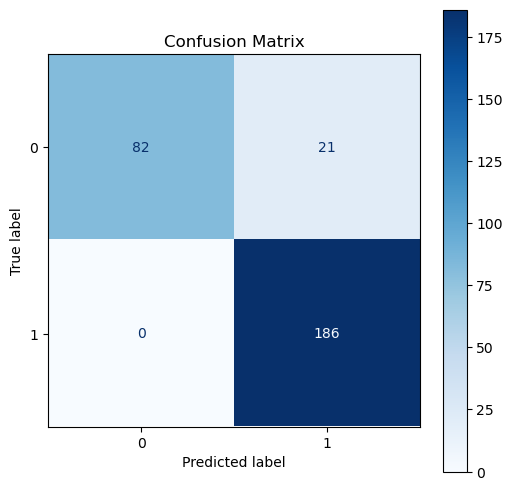

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       103
           1       0.90      1.00      0.95       186

    accuracy                           0.93       289
   macro avg       0.95      0.90      0.92       289
weighted avg       0.93      0.93      0.93       289



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=False, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true' if normalize else None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f" if normalize else "d")
    plt.title(title)
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_test, preds, normalize=False)
print(classification_report(y_test, preds))

The model seems to be doing quite good honestly! That's.. mindblowing!

### 2. Making the LSTM

Below is the LSTM classifier used for this task.

In [ ]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()

        # Embedding to be used
        self.embedding = nn.Embedding(vocab_size,embedding_dim, padding_idx=index['<PAD>'])

        # LSTM
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,batch_first=True)

        # Again separating the output layer
        self.classifier_back = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.ReLU()
        )
        self.classifier_head = nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self,x,return_features=False):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        features = self.classifier_back(hidden[-1])
        if return_features:
          return features

        return self.classifier_head(features)

Training loop..

In [ ]:
# Initializing the model, loss and optimizer
text_model = TextLSTM(len(vocab), 300, 128).to(device)

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(text_model.parameters(), 1e-3)

text_dataset = TensorDataset(X_train_text, y_train_tensor)
train_text_loader = DataLoader(text_dataset, batch_size=32, shuffle=True)

for epoch in range(20):
    text_model.train()
    total_loss = 0
    for x_i, y_i in train_text_loader:
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        optimizer.zero_grad()
        preds = text_model.forward(x_i)
        loss = loss_fn(preds,y_i)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/train_text_loader.batch_size}')

Epoch 1, Loss: 0.4248076155781746
Epoch 2, Loss: 0.30881642177700996
Epoch 3, Loss: 0.23577766529706423
Epoch 4, Loss: 0.18830894364509732
Epoch 5, Loss: 0.1834445253771264
Epoch 6, Loss: 0.2022001203149557
Epoch 7, Loss: 0.17750421901109803
Epoch 8, Loss: 0.34895626141224056
Epoch 9, Loss: 0.3018286060541868
Epoch 10, Loss: 0.25349803594872355
Epoch 11, Loss: 0.19111380592221394
Epoch 12, Loss: 0.2196476082317531
Epoch 13, Loss: 0.22935246489942074
Epoch 14, Loss: 0.23176245158538222
Epoch 15, Loss: 0.2146092765033245
Epoch 16, Loss: 0.19030975311034126
Epoch 17, Loss: 0.18337263535067905
Epoch 18, Loss: 0.17604238889180124
Epoch 19, Loss: 0.16077646327539696
Epoch 20, Loss: 0.16562887839972973


Let's see how this does against the test data..

In [ ]:
text_model.eval()
with torch.no_grad():
  preds = text_model(X_test_text.to(device)).cpu().numpy()

preds = (preds>0.5).astype(int)

plot_confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Once again, seems to be doing really good!

## Merging the Two Branches

So the idea here is to merge the final layers before the output and train a neural network on that.

Below is the implementation.

In [ ]:
class FusionClassifier(nn.Module):
  def __init__(self, tab_model, text_model, input_dims):
    super().__init__()
    self.tab_model = tab_model
    self.text_model = text_model

    # Simple MLP
    self.final_classifier = nn.Sequential(
        nn.Linear(input_dims, 64),
        nn.ReLU(),
        nn.Linear(64,1),
        nn.Sigmoid()
    )

  def forward(self, x_tab, x_text):
    # Extract the final two layers from the two models and classify
    tab_feats = self.tab_model(x_tab, return_features=True)
    text_feats = self.text_model(x_text, return_features=True)

    fused_features = torch.cat([tab_feats, text_feats], dim=1)
    return self.final_classifier(fused_features)

Training loop..

In [ ]:
# Define the necessary stuff
fusion_model = FusionClassifier(tab_model, text_model, input_dims=128).to(device)
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)

epochs = 10

fused_dataset = TensorDataset(X_train_tab, X_train_text, y_train_tensor)
fused_loader = DataLoader(fused_dataset, batch_size=32, shuffle=True)

for epoch in range(epochs):
  fusion_model.train()
  running_loss = 0.0

  for x_tab, x_text, y in fused_loader:
    x_tab = x_tab.to(device)
    x_text = x_text.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    preds = fusion_model(x_tab, x_text)
    loss = loss_fn(preds, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 0.26988649808547716
Epoch 2, Loss: 0.057646942494267765
Epoch 3, Loss: 0.023832706290043214
Epoch 4, Loss: 0.01825633538584787
Epoch 5, Loss: 0.008731355920727683
Epoch 6, Loss: 0.008003708995106123
Epoch 7, Loss: 0.02059665745003837
Epoch 8, Loss: 0.012661018276544795
Epoch 9, Loss: 0.006123613127949118
Epoch 10, Loss: 0.006673680270482278


Now to test it..

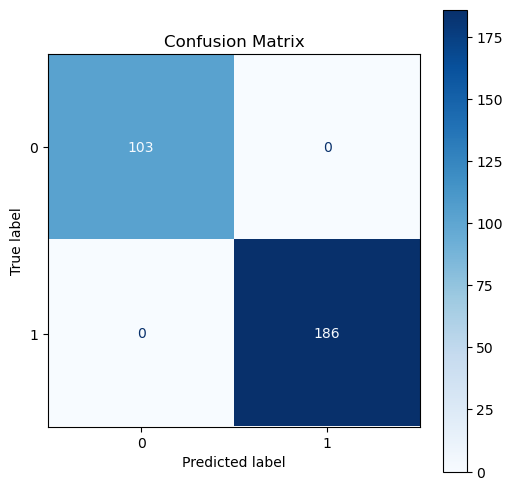

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00       186

    accuracy                           1.00       289
   macro avg       1.00      1.00      1.00       289
weighted avg       1.00      1.00      1.00       289



In [ ]:
  fusion_model.eval()
  with torch.no_grad():
      preds = fusion_model(X_test_tab.to(device), X_test_text.to(device)).cpu().numpy()

  preds = (preds>0.7).astype(int)
  plot_confusion_matrix(y_test, preds)
  print(classification_report(y_test, preds))

That.. was much better than expected!

Let's also plot the ROC curve.

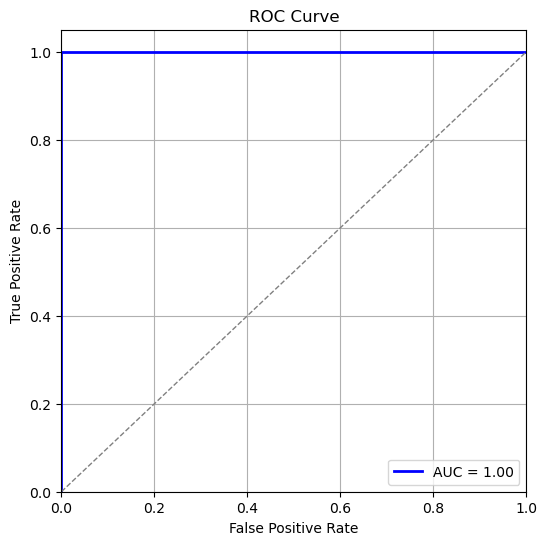

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_curve(y_test, preds)

## Comparison with Other Models

Let's compare our system with some other standard models trained on the tabular data.

### 1. Logistic Regression

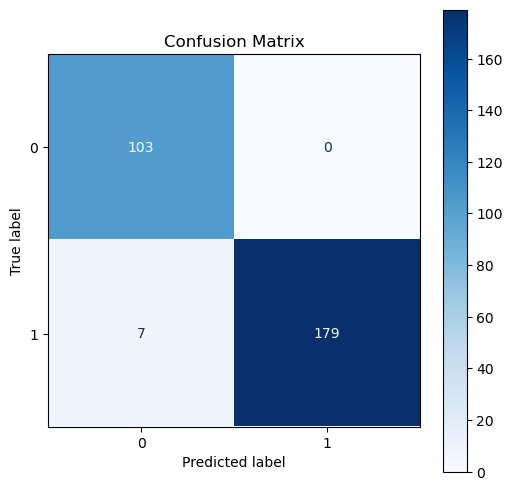

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       103
           1       1.00      0.96      0.98       186

    accuracy                           0.98       289
   macro avg       0.97      0.98      0.97       289
weighted avg       0.98      0.98      0.98       289



In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_tab, y_train)

preds = logreg.predict(X_test_tab.cpu())

plot_confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

### 2. Random Forest Classifier

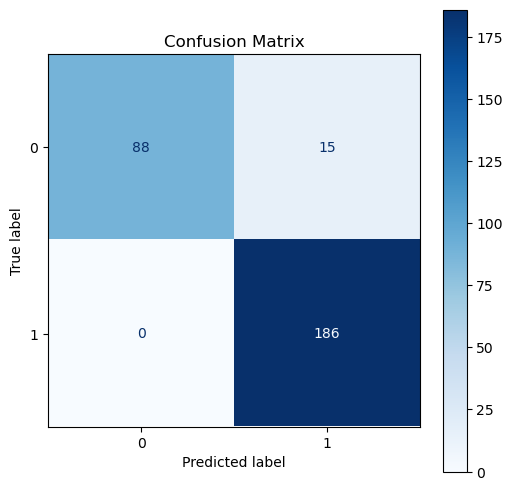

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.93      1.00      0.96       186

    accuracy                           0.95       289
   macro avg       0.96      0.93      0.94       289
weighted avg       0.95      0.95      0.95       289



In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train_tab, y_train)

preds = forest.predict(X_test_tab.cpu())

plot_confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

### 3. XGBClassifier

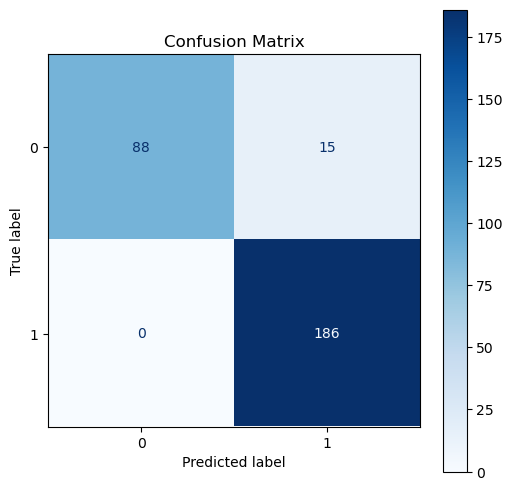

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       103
           1       0.93      1.00      0.96       186

    accuracy                           0.95       289
   macro avg       0.96      0.93      0.94       289
weighted avg       0.95      0.95      0.95       289



In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train_tab, y_train)

preds = xgb.predict(X_test_tab.cpu())
plot_confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

### 4. Support Vector Machine Classifier

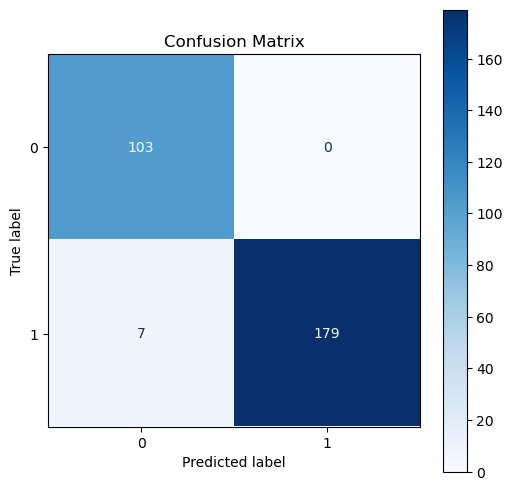

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       103
           1       1.00      0.96      0.98       186

    accuracy                           0.98       289
   macro avg       0.97      0.98      0.97       289
weighted avg       0.98      0.98      0.98       289



In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train_tab, y_train)

preds = svc.predict(X_test_tab.cpu())

plot_confusion_matrix(y_test, preds)
print(classification_report(y_test, preds))

All of the models perform fairly well on the data mostly because the labels were synthesized directly from the tabular data making it easier to find the patterns.

Says a lot when quality of data is good, then even the most basic models produce pretty good results!

And that's it for now!